# Algorithms for Big Data - Exercise 10
This lecture is focused on using CNN for object localization tasks.

You can download the dataset from this course on [Github](https://github.com/rasvob/2020-21-ARD/tree/master/datasets)

[Open in Google colab](https://colab.research.google.com/github/rasvob/2020-21-ARD/blob/master/abd_10.ipynb)
[Download from Github](https://github.com/rasvob/2020-21-ARD/blob/master/abd_10.ipynb)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import seaborn as sns
import tensorflow as tf
# import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import normalize # normalization of the matrix
import scipy
import pandas as pd

tf.version.VERSION

'2.3.0'

In [2]:
import requests
from typing import List, Tuple

In [3]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

# What is Object Localization?
Object localization is the name of the task of “classification with localization”. Namely, given an image, classify the object that appears in it, and find its location in the image, usually by using a bounding-box. 

In Object Localization, only a single object can appear in the image. If more than one object can appear, the task is called “Object Detection”.

![model](https://github.com/rasvob/2020-21-ARD/raw/master/images/class_vs_loc.png)

Object Localization can be treated as a regression problem - predicting a continuous value, such as a weight or a salary. For instance, we can represent our output (a bounding-box) as a tuple of size 4, as follows:

- (x,y, height, width)
    - (x,y): the coordination of the left-top corner of the bounding box
    - height: the height of the bounding box
    - width: the width of the bounding box
    
![model](https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/images/cat_bound.png)

### Network architecture in general

The coordination of the left-top corner of the bounding box must be inside the image and so do x+width and y+height. 

We will scale the image width and height to be 1.0. To make sure that the CNN outputs will be in the range [0,1], we will use the sigmoid activation layer - it will enforce that (x,y) will be inside the image, but not necessarily x+width and y+height. 

This property will be learned by the network during the training process.

![model](https://raw.githubusercontent.com/rasvob/2020-21-ARD/master/images/loc_arch.png)

### What about the loss?

The output of a sigmoid can be treated as probabilistic values, and therefore we can use **Binary crossentropy** loss. 
You can see [this](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/binary-crossentropy) for more informations.

# We will start with purely synthetic use-case for educational purposes before we start to implement more complex one
Our task will be the detection of white circles on pure black background. We will assume that the white blobs will be located in square bounding boxes for simplicity.

In [4]:
dataset_size = 512
X = np.zeros((dataset_size, 128, 128, 1))
labels = np.zeros((dataset_size, 3))
# fill each image
for i in range(dataset_size):
    x = np.random.randint(8,120)
    y = np.random.randint(8,120)
    a = min(128 - max(x,y), min(x,y))
    r = np.random.randint(4,a)
    for x_i in range(128):
      for y_i in range(128):
        if ((x_i - x)**2) + ((y_i - y)**2) < r**2:
          X[i, x_i, y_i,:] = 1
    labels[i,0] = (x-r)/128.0
    labels[i,1] = (y-r)/128.0
    labels[i,2] = 2*r / 128.0

In [5]:
X.shape

(512, 128, 128, 1)

In [6]:
labels.shape

(512, 3)

# Single example of generated image

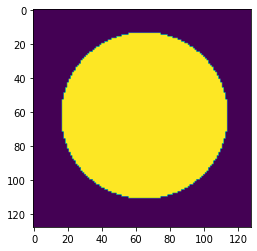

In [7]:
plt.imshow(X[0])

In [8]:
from matplotlib.patches import Rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[1]*128,p[0]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()

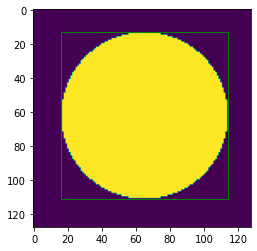

In [9]:
plot_pred(X[0], labels[0])

# More examples of our input data with bounding boxes

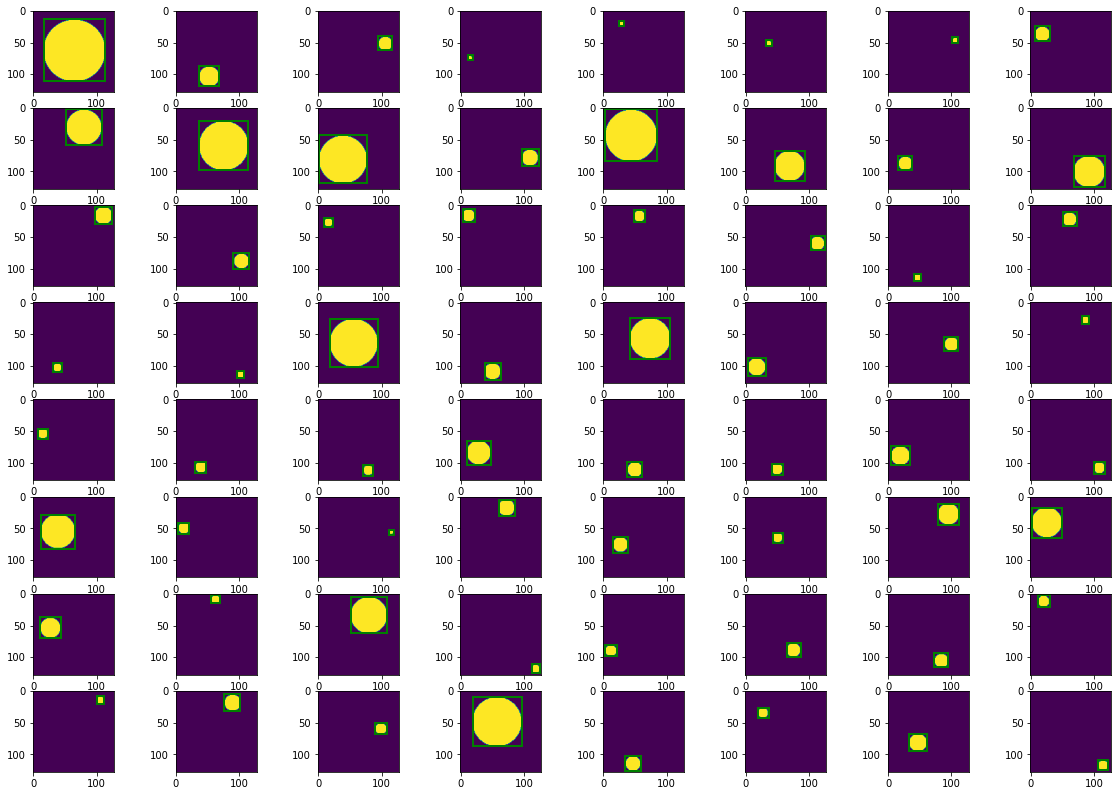

In [10]:
fig, ax = plt.subplots(8, 8, figsize=(20, 14))
for i in range(8):
    for j in range(8):
        img = X[i*8 + j]
        p = labels[i*8 + j]
        ax[i, j].imshow(img)
        rect = Rectangle(xy=(p[1]*128,p[0]*128),width=p[2]*128, height=p[2]*128, linewidth=2,edgecolor='g',facecolor='none')
        ax[i, j].add_patch(rect)

## Let's define our first object localization model

In [42]:
model = keras.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(128,128,1)),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(3, activation='sigmoid'),
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 16)        9232      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4096)             

#### Fit the model on the train data.
Lets train the model on the training data and find the best model using the ModelCheckpoint callback to find the best model avaialble and achievable.

# Beware! Early stopping callback is probably bugged (or perhaps it is a feature, one never knows nowadays... :)) in case of weights restoration!
Early stopping restores best weights only if the training was stopped by the callback, if the training was finished it leaves the last trained weights in place.
You can see [https://github.com/keras-team/keras/issues/12511](https://github.com/keras-team/keras/issues/12511) for more detailed discussion.

Thanks go to Ondrej Chovanec who found about the issue on the internet.

## There is a possible fix involving the ModelCheckpoint so we will try this one in this lecture

In [43]:
train_x, test_x, train_y, test_y = train_test_split(X, labels, test_size=0.2, random_state=42)

In [44]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/100
11/11 [==============================] - 0s 37ms/step - loss: 0.6432 - accuracy: 0.5902 - val_loss: 0.5799 - val_accuracy: 0.8049
Epoch 2/100
11/11 [==============================] - 0s 25ms/step - loss: 0.5688 - accuracy: 0.7584 - val_loss: 0.5267 - val_accuracy: 0.8537
Epoch 3/100
11/11 [==============================] - 0s 25ms/step - loss: 0.5402 - accuracy: 0.7859 - val_loss: 0.5239 - val_accuracy: 0.8659
Epoch 4/100
11/11 [==============================] - 0s 26ms/step - loss: 0.5318 - accuracy: 0.8104 - val_loss: 0.5146 - val_accuracy: 0.8537
Epoch 5/100
11/11 [==============================] - 0s 27ms/step - loss: 0.5259 - accuracy: 0.8257 - val_loss: 0.5123 - val_accuracy: 0.9024
Epoch 6/100
11/11 [==============================] - 0s 27ms/step - loss: 0.5229 - accuracy: 0.8349 - val_loss: 0.5118 - val_accuracy: 0.9024
Epoch 7/100
11/11 [==============================] - 0s 27ms/step - loss: 0.5212 - accuracy: 0.8654 - val_loss: 0.5089 - val_accuracy: 0.9024
Epoch 

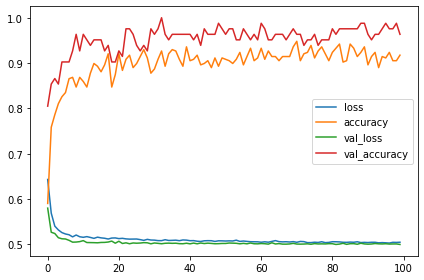

In [45]:
batch_size = 32
epochs = 100
history = model.fit(train_x, train_y, validation_split=0.2, callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

show_history(history)

In [46]:
model.load_weights("weights.best.hdf5")

In [47]:
test_loss, test_acc = model.evaluate(test_x, test_y)

4/4 [==============================] - 0s 5ms/step - loss: 0.4728 - accuracy: 0.9515


In [48]:
model.evaluate(train_x, train_y)

13/13 [==============================] - 0s 8ms/step - loss: 0.4950 - accuracy: 0.9633


[0.49504005908966064, 0.9633252024650574]

# Now we can take a look at our predictions using the model
We can see that sometimes the prediction is slightly off but usually not by much.

In [49]:
y_pred = model.predict(test_x)

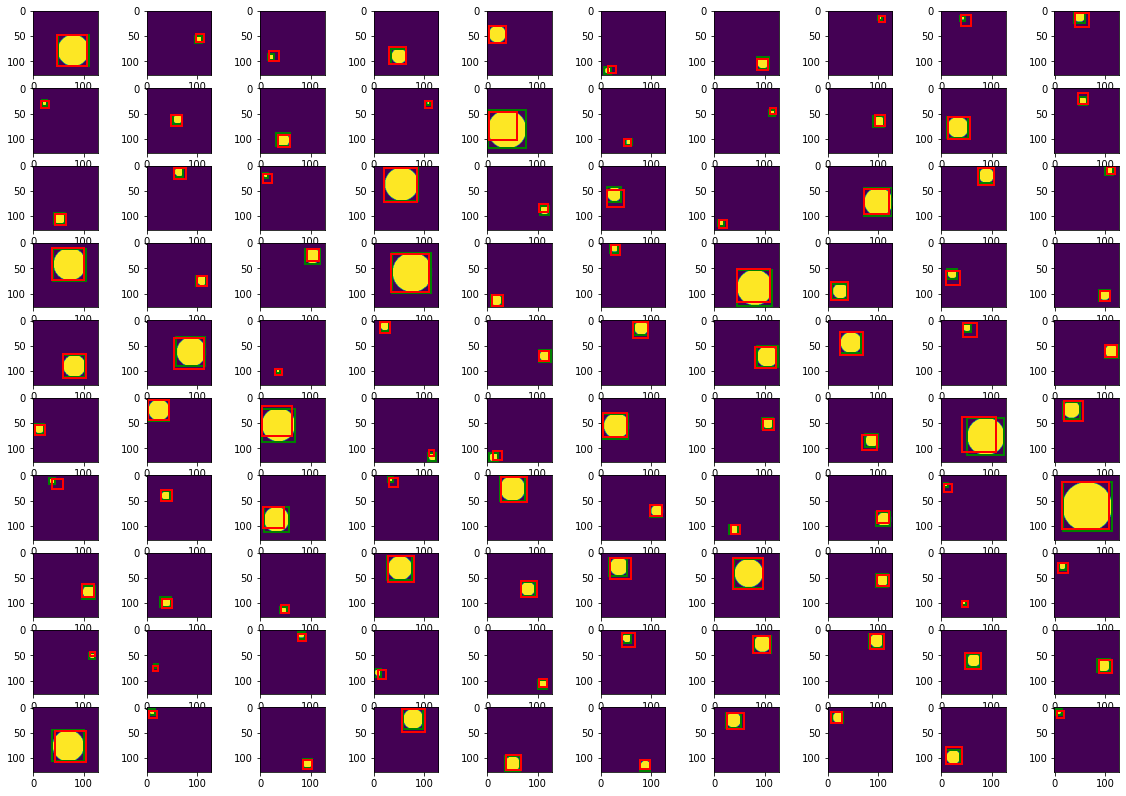

In [55]:
nrows = 10
fig, ax = plt.subplots(nrows, nrows, figsize=(20, 14))
for i in range(nrows):
    for j in range(nrows):
        img = test_x[i*nrows + j]
        p = test_y[i*nrows + j]
        predicted = y_pred[i*nrows + j]
        ax[i, j].imshow(img)
        rect = Rectangle(xy=(p[1]*128,p[0]*128),width=p[2]*128, height=p[2]*128, linewidth=2,edgecolor='g',facecolor='none')
        ax[i, j].add_patch(rect)
        rect = Rectangle(xy=(predicted[1]*128,predicted[0]*128),width=predicted[2]*128, height=predicted[2]*128, linewidth=2,edgecolor='r',facecolor='none')
        ax[i, j].add_patch(rect)

# Now we know the basics so we can focus on more realistic stuff
Usually you don't want to train your own CNN model for the task, but you try to leverage transfer learning approach.
Object localization is no exception. 

You can read the [ about the API.

# Task for the lecture
 - Choose another simple structured dataset - Iris for example
 - Choose either Estimator or TF Preprocessing layers approach - use Normalization layers for example
 - Build classification model using chosen approach
 - Experiment a little
 - Send me the Colab notebook with results and description of what you did and your final solution!